# GPT-2 interpretability

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d6/gpt-2_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logit lens

### First step: understanding Logit lens

Read: https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens

### Second step: Reproducing the results

Reimplement the Logit lens in a minimal way by reproducing the figure at the end of this section.
This exercice is quite unguided because being able to use the transformer library autonomously is very important.

Resources if you are stuck:
- Read about hooks here https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks
- pip install transformer-utils and use the function _plot_logit_lens https://github.dev/nostalgebraist/transformer-utils/tree/main/src/transformer_utils/logit_lens


You should optain this figure:

![](results.png)

In [3]:
!pip install transformers transformer_utils jaxtyping einops typeguard==2.13.3 -q

In [108]:
from functools import partial

import einops
import torch
import transformers
from jaxtyping import Float, Int, jaxtyped
from torch import Tensor
from transformer_utils.logit_lens.plotting import _plot_logit_lens
from typeguard import typechecked

Hints:
- GPT-2 has tied embeddings, so the embedding and unembedding matrices are the same. You can access them with `model.base_model.wte.weight`
- Do not forget to apply the final LayerNorm to normalise the residual stream before applying the softmax. You can access it with `model.base_model.ln_f`

In [51]:
# Loading GPT2 and its tokenizer
gpt2 = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
gpt2_tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
gpt2.eval()

# Looking at the model to see the name of the different layers
print(gpt2)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
@jaxtyped
@typechecked
def plot_logit_lens(
    per_layer_logits: Float[Tensor, "layer nb_tokens vocab=50257"],
    per_layer_token_to_show: Int[Tensor, "layer nb_tokens"],
    input_ids: Int[Tensor, "batch=1 nb_tokens"],
    tokenizer=gpt2_tokenizer,
):
    _plot_logit_lens(
        per_layer_logits.detach(),
        per_layer_token_to_show.detach(),
        per_layer_logits.softmax(dim=-1).detach(),
        tokenizer,
        # Hack: add the end-of-text token to avoid crash in _plot_logit_lens
        input_ids=torch.cat([input_ids, torch.tensor([[50256]])], dim=1),
        # input_ids=input_ids,
        start_ix=0,
        layer_names=None,
        probs=True,
    )


 birthday get're which happy anniversary get
, birthday get're which happy anniversary get
, holidays celebrate guys please happy anniversary get
, anniversary celebrate guys please happy anniversary be
, anniversary celebrate guys please happy! celebrate
, anniversary celebrate guys please birthday! be
,! thank guys dear birthday! everyone
,! thank guys dear birthday! everyone
,! my guys dear birthday to everyone
,! my guys dear birthday to everyone
, to my guys dear birthday to everyone
,, you, my birthday to all


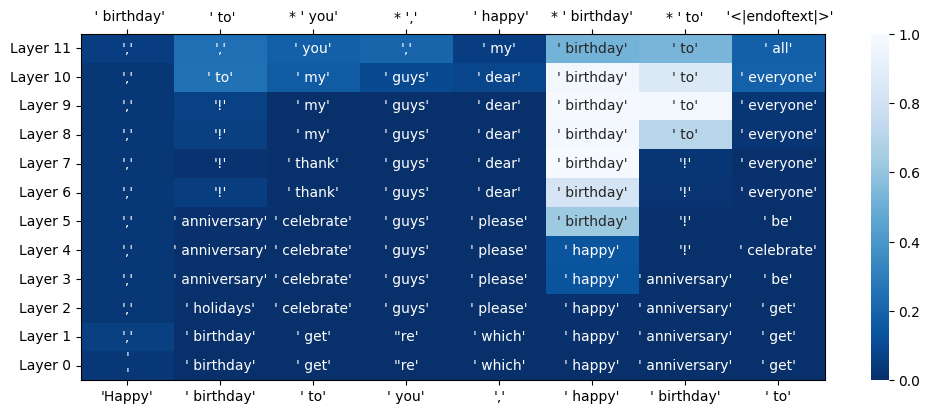

In [111]:
prompt = "Happy birthday to you, happy birthday to"

...  # Implement logit lens

plot_logit_lens(
    per_layer_logits,
    per_layer_token_to_show,
    input_ids,
)


<details>
  <summary>Hint: steps</summary>

```python
# 1. Define a hook that stores the output of the layer
# 2. Add the hook to each layer, use partial to pass the layer index
# 3. Run the model on the input, then remove the hooks
# 4. For each layer
# 4.1. Normalize the output using the final layer norm
# 4.2. Compute the word distribution using the word embeddings
# 4.3. Find the most likely token
```
</details>

<details>
  <summary>Click to see the solution</summary>

```python
n_layers_gpt = len(gpt2.base_model.h)
outputs = [None] * n_layers_gpt

input_ids = gpt2_tokenizer.encode(prompt, return_tensors="pt")

# 1. Define a hook that stores the output of the layer
def memorize_output_layer_hook(self, input, output, layer):
    # Remark: the `global` keyword is not necessary, because we are modifying 
    # the content of a list. `global` would have been necessary if we were
    # overwriting the list (i.e. outputs = ...)
    outputs[layer] = output[0].detach()


# 2. Add the hook to each layer, use partial to pass the layer index
handles = [
    gpt_block.register_forward_hook(partial(memorize_output_layer_hook, layer=layer))
    for layer, gpt_block in enumerate(gpt2.base_model.h)
]

# 3. Run the model on the input, then remove the hooks
try:
    with torch.no_grad():
        gpt2(input_ids)
finally:
    for handle in handles:
        handle.remove()


last_layer_norm = gpt2.base_model.ln_f
word_embeddings = gpt2.base_model.wte.weight

# 4. For each layer
# 4.1. Normalize the output using the final layer norm
# 4.2. Compute the word distribution using the word embeddings
# 4.3. Find the most likely token

per_layer_token_to_show = []
per_layer_logits = []

for layer, output in enumerate(outputs):
    normalized_output = last_layer_norm(output)

    word_distribution = einops.einsum(
        normalized_output, word_embeddings, 
        "batch token d_model, vocab d_model -> token vocab"
    )
    best_token = torch.argmax(word_distribution, dim=-1)
    output_text = gpt2_tokenizer.decode(best_token)
    print(output_text)
    
    per_layer_token_to_show.append(best_token) 
    per_layer_logits.append(word_distribution) 
    

per_layer_logits = torch.stack(per_layer_logits)
per_layer_token_to_show = torch.stack(per_layer_token_to_show)
```
</details>

## Probing

Look at this youtube video to introduce you to probing: https://www.youtube.com/watch?v=HJn-OTNLnoE

We will use the fetch_20newsgroups dataset, and we will classify the news according to which journal they come from.
We will try to implement a small probe and analyse each layer of GPT-2. Which layer contains most of the information we are insterested with?

Questions: 
- What is your strategy to use the internal states of gpt-2 as features for classification?
- Propose 2 other strategies that won't work.
- Try to predict the score of each layer at classifying the fetch_20newsgroups dataset.
- Implement and check your prediction.

Bonu read this: https://arxiv.org/pdf/1704.01444.pdf



In [7]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
              
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [8]:
print(twenty_train.data[0])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [9]:
twenty_train.target[0]

1

In [10]:
twenty_train.target_names[twenty_train.target[0]]

'comp.graphics'

In [11]:
len(twenty_train.target)

2257

https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.CausalLMOutputWithCrossAttentions

In [ ]:
import numpy as np
import torch
from tqdm.auto import tqdm

torch.cuda.empty_cache()
embed_dim = 768
n_layers = 12
N = len(twenty_train.data)

# We only take the last token
# If you do not put everything in a single array, the memory explodes
hidden_states = np.zeros((N, n_layers, embed_dim))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activations = np.zeros((N, n_layers, embed_dim))

gpt2 = gpt2.to(device)
gpt2.eval()


# Fill hidden_states
...


In [ ]:
np.save("hidden_states", hidden_states)
hidden_states.shape

In [ ]:
# If you do not have a gpu, use this line.
# hidden_states = np.load("hidden_states.npy")

In [ ]:
# Check the documentation of sklearn and use those imports to score each layer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores = []
for layer in range(n_layers):
    ...
  

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(scores))), scores)

# Activation Atlas

With out dataset we can also try to minimally reproduce the activation atlas paper:
https://openai.com/blog/introducing-activation-atlases/


Questions:
- How to implement dimensionality reduction?
- Install umap-learn.
- Visualize the umap of the best previously selected layer. Comment.

Bonus: Plot the sentences alongside the point in the UMAP plot. Chack that everything makes sense.

In [22]:
!pip install umap-learn -q

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering library
import umap as umap

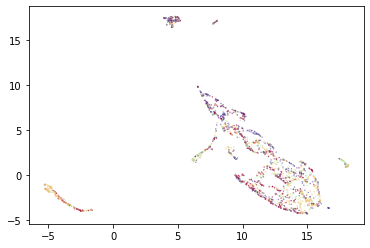

In [21]:
# Choose the best_layer
best_layer = ...
X = hidden_states[:, best_layer, :]
y = twenty_train.target

standard_embedding = umap.UMAP(random_state=42).fit_transform(X_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y.astype(int), s=0.1, cmap='Spectral');